# Moran I – Monte Carlo

## Libraries and cwd

In [1]:
library(sf)
library(spdep)
library(tmap)

Linking to GEOS 3.11.2, GDAL 3.6.2, PROJ 9.2.0; sf_use_s2() is TRUE

Loading required package: spData

To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`

Warning message:
"package 'tmap' was built under R version 4.3.1"


## Load the data

In [2]:
# Load the shapefile
s <- readRDS(url("https://github.com/mgimond/Data/raw/gh-pages/Exercises/nhme.rds"))

In [21]:
st_crs(s)

old-style crs object detected; please recreate object with a recent sf::st_crs()



Coordinate Reference System:
  User input: +proj=eqdc +lat_0=40 +lon_0=-96 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs 
  wkt:
PROJCRS["unknown",
    BASEGEOGCRS["unknown",
        DATUM["North American Datum 1983",
            ELLIPSOID["GRS 1980",6378137,298.257222101,
                LENGTHUNIT["metre",1]],
            ID["EPSG",6269]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8901]]],
    CONVERSION["unknown",
        METHOD["Equidistant Conic"],
        PARAMETER["Latitude of natural origin",40,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",-96,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Latitude of 1st standard parallel",20,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8823]],
        PARAMETER["Latitude of 2nd standard parallel"

## Explore the data and data wrangling

In [3]:
names(s)

[1] "NAME"       "STATE_NAME" "POP10_SQMI" "AVE_HH_SZ"  "AVE_FAM_SZ"
[6] "Income"     "House_year" "geometry"

In [4]:
s$Income

[1] 45765 59560 46559 50515 50027 40695 55046 43484 56701 60782 52393 56139
[13] 55045 70906 65226 79368 59580 56851 37378 41665 45747 44543 37110 39792
[25] 38239 42407

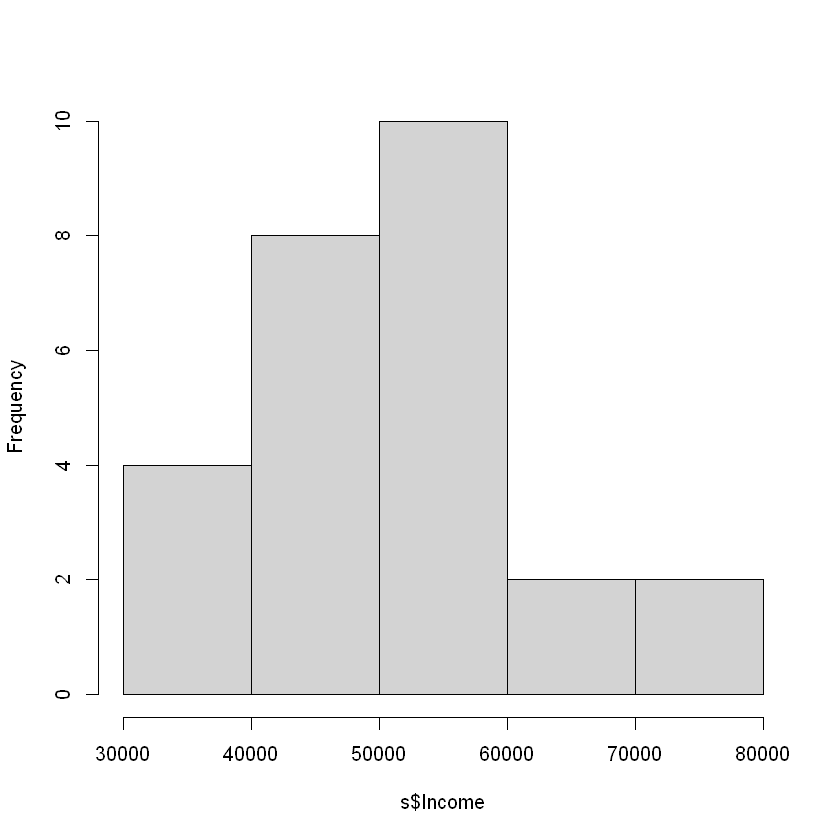

In [5]:
hist(s$Income, main=NULL)

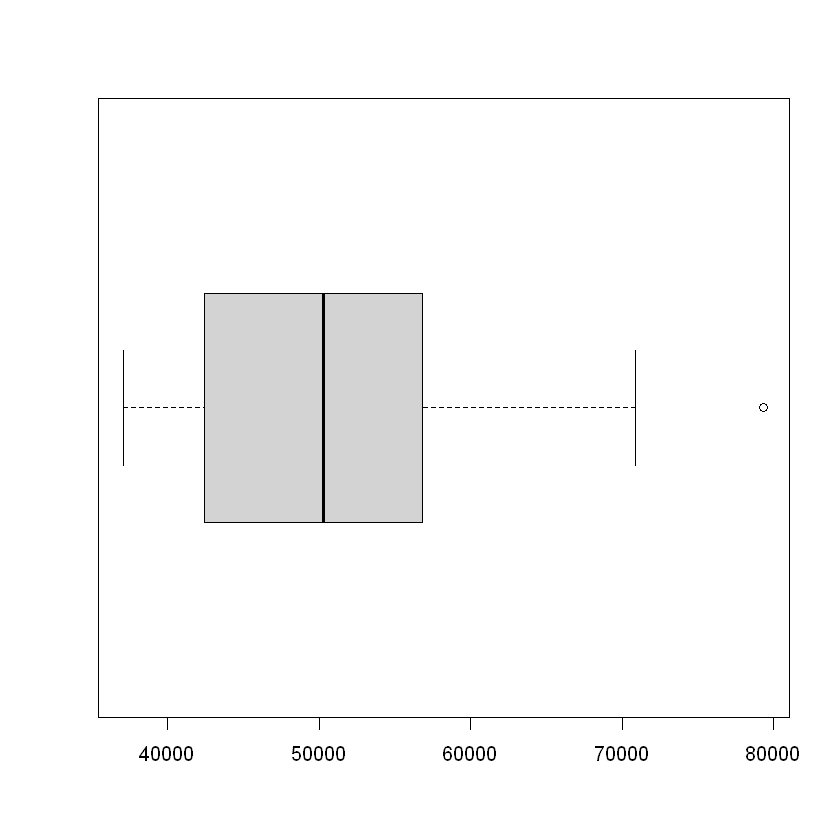

In [6]:
boxplot(s$Income, horizontal = TRUE)

old-style crs object detected; please recreate object with a recent sf::st_crs()

old-style crs object detected; please recreate object with a recent sf::st_crs()

old-style crs object detected; please recreate object with a recent sf::st_crs()

old-style crs object detected; please recreate object with a recent sf::st_crs()

old-style crs object detected; please recreate object with a recent sf::st_crs()



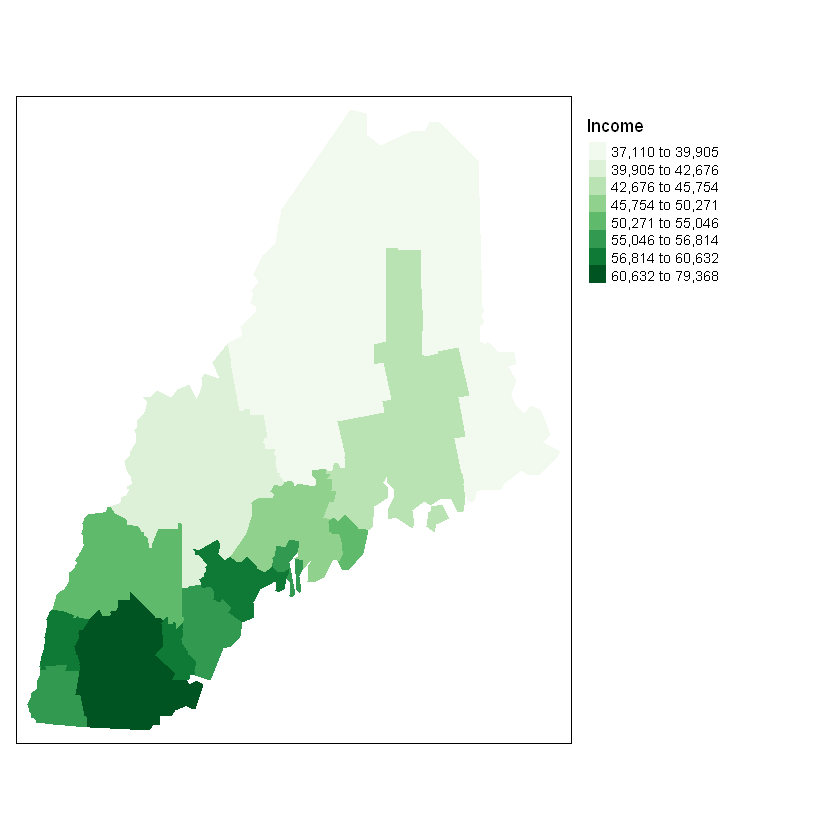

In [7]:
tm_shape(s) + tm_fill(col = "Income", style = "quantile", n = 8, palette = "Greens") +
    tm_legend(outside = TRUE)

## Step 1: Define neighboring polygons


The first step in a Moran’s I analysis requires that we define “neighboring” polygons. This could refer to contiguous polygons, polygons within a certain distance, or it could be non-spatial in nature and defined by social, political or cultural “neighbors”.

Here, we’ll adopt a contiguous neighbor definition. We’ll accept any contiguous polygons that share at least one vertex; this is the “queen” case (if one chooses to adopt the chess analogy) and it’s parameterized as queen = TRUE in the call to poly2nb. If we required that just edges be shared between polygons then we would set queen = FALSE (the rook analogy).

In [9]:
nb <- poly2nb(s, queen = TRUE)
nb[1]

old-style crs object detected; please recreate object with a recent sf::st_crs()

old-style crs object detected; please recreate object with a recent sf::st_crs()



old-style crs object detected; please recreate object with a recent sf::st_crs()



[[1]]
[1]  2  3  6  7 20

## Step 2: Assign weights to the neighbors

Next, we need to assign weights to each neighboring polygon. In this example, each neighboring polygon will be assigned equal weight when computing the neighboring mean variable (num_of_blds) values.

In [11]:
lw <- nb2listw(nb, style = "W", zero.policy = TRUE)
lw$weights[1]

[[1]]
[1] 0.2 0.2 0.2 0.2 0.2

These are the weights each neighboring income value will be multiplied by before being summed. If a polygon has 5 neighbors, each neighbor will have a weight of 1/5 or 0.2. This weight will then be used to compute the mean neighbor values as in 0.2(neighbor1) + 0.2(neighbor2) + 0.2(neighbor3) + 0.2(neighbor4) + 0.2(neighbor5). This is equivalent to summing all five income values then dividing by 5.

## Step 3 (optional): Compute the (weighted) neighbor mean variable (num_of_blds) values

NOTE: This step does not need to be performed when running the moran or moran.test functions outlined in Steps 4 and 5. This step is only needed if you wish to generate a scatter plot between the variable (num_of_blds) values and their lagged states.

Next, we’ll have R compute the average neighbor variable (num_of_blds) value for each polygon. These values are often referred to as spatially lagged values.

In [12]:
inc.lag <- lag.listw(lw, s$Income)
inc.lag

[1] 48705.00 49551.75 45963.17 46755.50 48901.00 49748.50 50477.75 46197.17
 [9] 53057.00 58061.00 52535.00 63878.50 55531.80 64396.00 63755.33 65237.33
[17] 62894.00 61829.00 39921.00 43202.75 42088.67 40291.67 40571.00 41789.83
[25] 42556.00 49377.67

You can plot the relationship between income and its spatially lagged counterpart as follows. The fitted blue line added to the plot is the result of an OLS regression model.

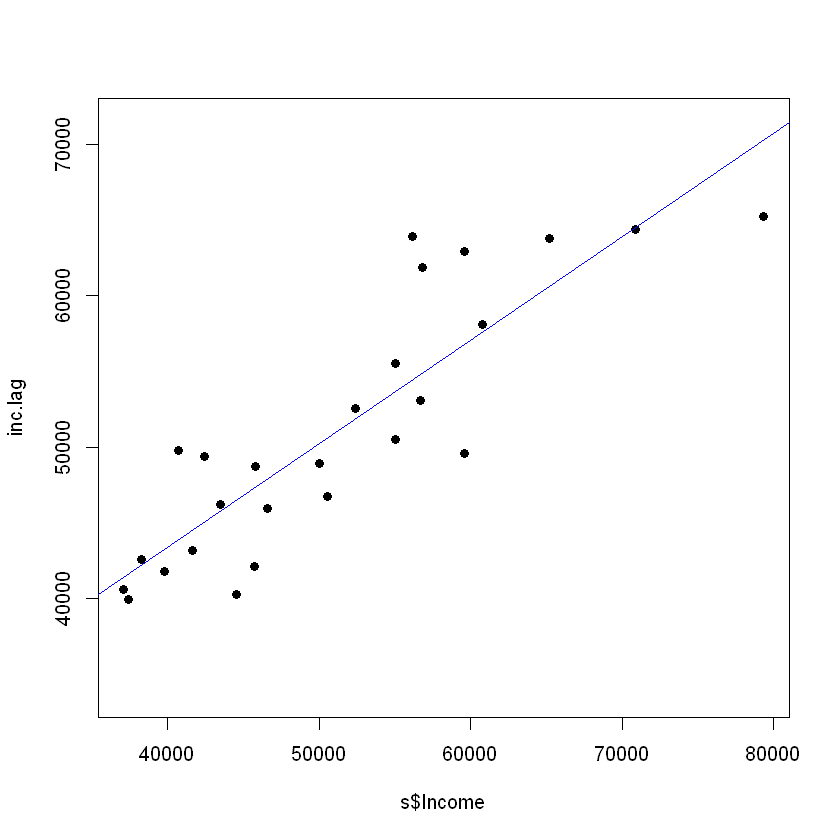

In [13]:
plot(inc.lag ~ s$Income, pch = 16, asp = 1)
M1 <- lm(inc.lag ~ s$Income)
abline(M1, col = "blue")

In [14]:
coef(M1)[2]

s$Income 
0.6827955

NOTE:
The moran’s I coefficient is 0.68. The positive (upward) slope suggests that as the income value of a said polygon increases, so does those of its neighboring polygons. If the slope were negative (i.e. sloping downward), this would suggest a negative relationship whereby increasing values in a said polygon would be surrounded by polygons with decreasing income values.

## Step 4: Computing the Moran’s I statistic

The Moran’s I statistic can be computed using the moran function.

In [15]:
I <- moran(s$Income, lw, length(nb), Szero(lw))[1]
I

$I
[1] 0.6827955

Recall that the Moran’s I value is the slope of the line that best fits the relationship between neighboring income values and each polygon’s income in the dataset.

## Step 5: Performing a hypothesis test

The hypothesis we are testing states that “the income values are randomly distributed across counties following a completely random process”. There are two methods to testing this hypothesis: an analytical method and a Monte Carlo method. We’ll explore both approaches in the following examples.

Analytical method

To run the Moran’s I analysis using the analytical method, use the moran.test function.

In [16]:
moran.test(s$Income, lw, alternative = "greater")


	Moran I test under randomisation

data:  s$Income  
weights: lw    

Moran I statistic standard deviate = 5.8525, p-value = 2.421e-09
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
       0.68279551       -0.04000000        0.01525284 


The Moran’s I statistic is 0.683 (same value that was computed using the moran function, as expected). The p-value is very small. Usually, when the p-value is very small it’s common practice to report it as < 0.001.

Note that ArcMap adopts this analytical approach to its hypothesis test however, it implements a two-sided test as opposed to the one-sided test adopted in the above example (i.e. alternative = "greater"). A two-sided p-value is nothing more than twice the one-sided p-value. Unfortunately, ArcMap does not seem to make this important distinction in any of its documentation. This distinction can have important ramifications as shown in the next example (Florida crime data). Fortunately, the income data is so strongly clustered that both a one-sided and two-sided test produce the same outcome (a p-value close to 0).

Monte Carlo method

The analytical approach to the Moran’s I analysis benefits from being fast. But it may be sensitive to irregularly distributed polygons. A safer approach to hypothesis testing is to run an MC simulation using the moran.mc() function. The moran.mc function takes an extra argument n, the number of simulations.

In [17]:
MC <- moran.mc(s$Income, lw, nsim = 999, alternative = "greater")

# View results (including p-value)
MC


	Monte-Carlo simulation of Moran I

data:  s$Income 
weights: lw  
number of simulations + 1: 1000 

statistic = 0.6828, observed rank = 1000, p-value = 0.001
alternative hypothesis: greater


The MC simulation generates a very small p-value, 0.001. This is not surprising given that the income values are strongly clustered. We can see the results graphically by passing the Moran’s I model to the plot function:

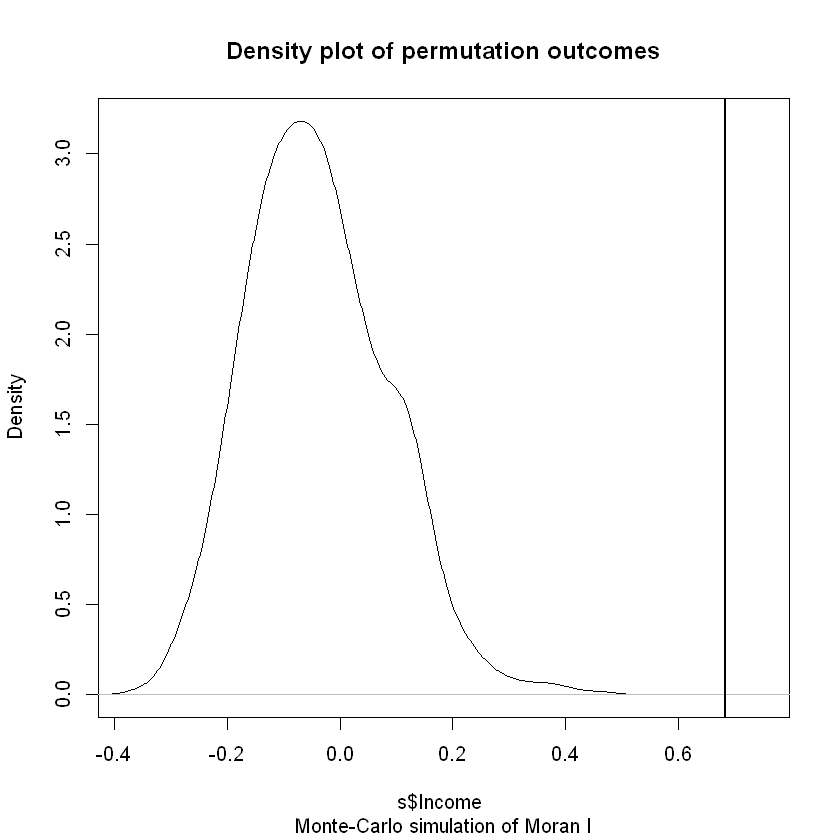

In [18]:
# Plot the Null distribution (note that this is a density plot instead of a histogram)
plot(MC)

The curve shows the distribution of Moran I values we could expect had the incomes been randomly distributed across the counties. Note that our observed statistic, 0.683, falls way to the right of the distribution suggesting that the income values are clustered (a positive Moran’s I value suggests clustering whereas a negative Moran’s I value suggests dispersion).

Now, had the Moran’s I statistic been negative (suggesting a dispersed pattern), you would probably want to set the alternative argument to less thus giving you the fraction of simulated I values more dispersed than your observed I value.

A visual exercise that you can perform to assess how “typical” or “atypical” your pattern may be relative to a randomly distributed pattern is to plot your observed pattern alongside a few simulated patterns generated under the null hypothesis.

old-style crs object detected; please recreate object with a recent sf::st_crs()

old-style crs object detected; please recreate object with a recent sf::st_crs()

old-style crs object detected; please recreate object with a recent sf::st_crs()

old-style crs object detected; please recreate object with a recent sf::st_crs()

old-style crs object detected; please recreate object with a recent sf::st_crs()



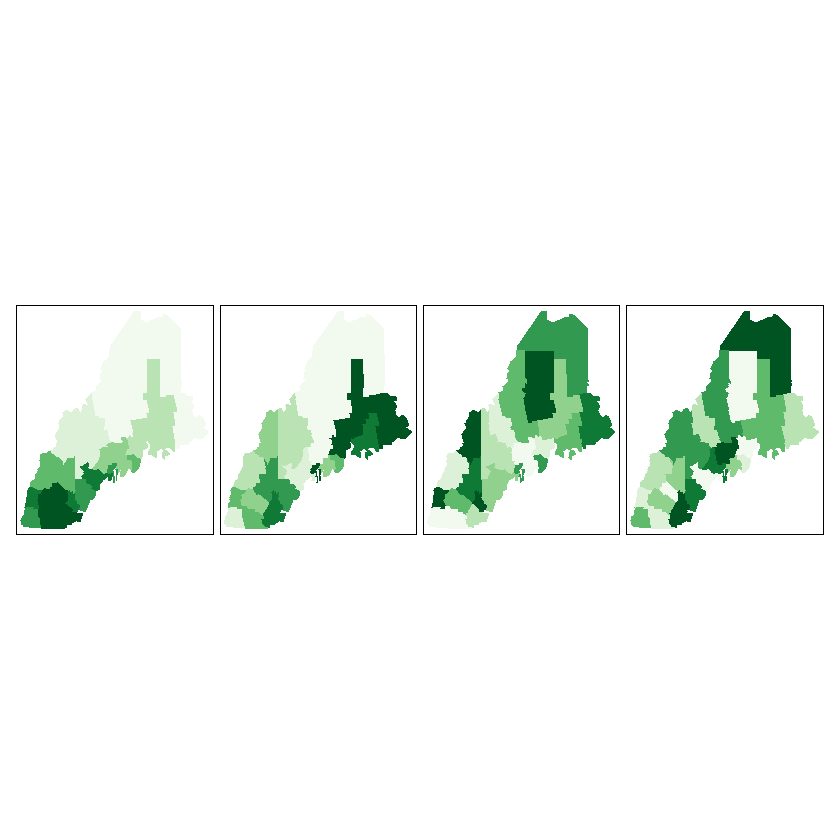

In [19]:
set.seed(131)
s$rand1 <- sample(s$Income, length(s$Income), replace = FALSE)
s$rand2 <- sample(s$Income, length(s$Income), replace = FALSE)
s$rand3 <- sample(s$Income, length(s$Income), replace = FALSE)

tm_shape(s) + tm_fill(
    col = c("Income", "rand1", "rand2", "rand3"),
    style = "quantile", n = 8, palette = "Greens", legend.show = FALSE
) +
    tm_facets(nrow = 1)

## Another example

old-style crs object detected; please recreate object with a recent sf::st_crs()

old-style crs object detected; please recreate object with a recent sf::st_crs()

old-style crs object detected; please recreate object with a recent sf::st_crs()




	Monte-Carlo simulation of Moran I

data:  s$HR80 
weights: lw  
number of simulations + 1: 10000 

statistic = 0.13628, observed rank = 9575, p-value = 0.0425
alternative hypothesis: greater


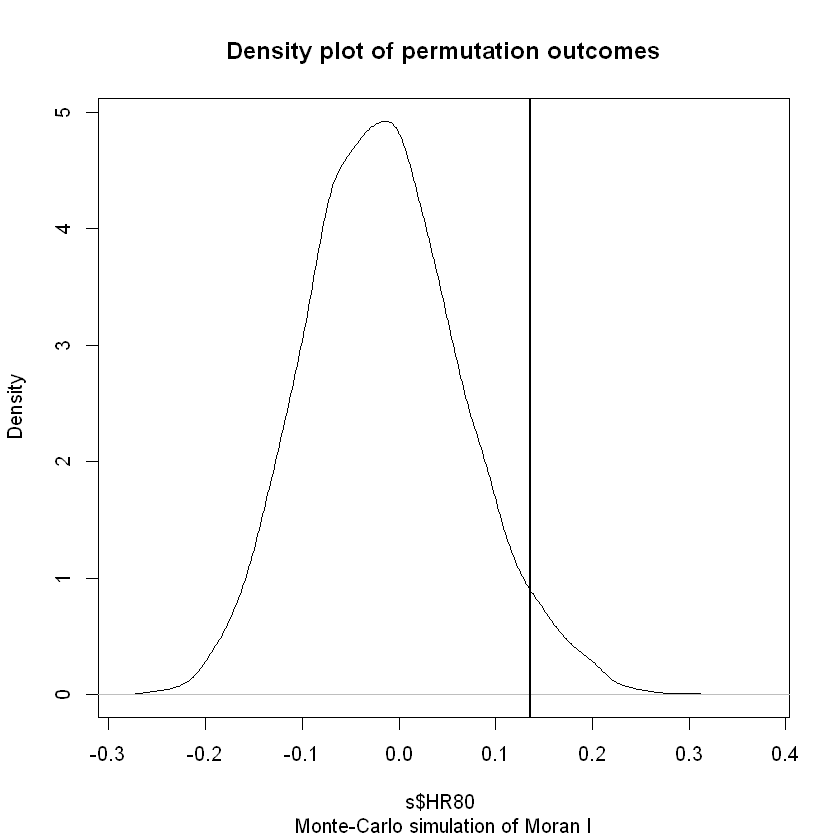

In [20]:
set.seed(2354)
# Load the shapefile
s <- readRDS(url("https://github.com/mgimond/Data/raw/gh-pages/Exercises/fl_hr80.rds"))

# Define the neighbors (use queen case)
nb <- poly2nb(s, queen = TRUE)

# Compute the neighboring average homicide rates
lw <- nb2listw(nb, style = "W", zero.policy = TRUE)

# Run the MC simulation version of the Moran's I test
M1 <- moran.mc(s$HR80, lw, nsim = 9999, alternative = "greater")

# Plot the results
plot(M1)

# Display the resulting statistics
M1